# CalTech 101 - Object classification

In this experiment, we're going to do object classification using Caltech 101 dataset. The dataset is available [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion). The dataset contains images of 101 different objects, but isn't a large dataset. In fact, average number of images per category is just about 50.

In this notebook, we do the following:
1. **Imports** -- For each import, I've given the reason so it doesn't feel like a bunch of imports just put together.

2. **[Download the dataset from the URL and extract it](#Download-the-dataset-to-a-folder-inside-this-directory)**

3. **[Exploring dataset](#Exploring-dataset)** -- Here, we write basic methods to read images programmatically and check their shapes. Further, we see [how many images do we have per category](#How-many-images-we-have-for-each-category?)

4. **[Create Dataset for ML](#Creating-Dataset-for-some-ML)** -- When you wish to use any frameworks/tools and do some machine learning, you need to have your training data, and testing data in a standard format. We will be creating our X and Y here. For object categories, we turn them to [one-hot encoded labels](#Making-one-hot-encoded-labels), and X is a [normalized numpy image array](#Basic-Normalization-(in-case-of-images)).
Finally, we split the data to training and validation data. We choose 75% for training and 25% for validation purposes.

5. **We try three different convolutional network approaches**, out of which two are written from scratch to test how they perform, while one is based on transfer learning and uses InceptionV3 as base model. We use Keras for this. An idea is brought from [SimpNet](https://arxiv.org/abs/1802.06205) paper, which is to not overly complicate the architecture or use larger kernel sizes without trying for smaller kernel sizes. Another thing that's common between both architectures is the use of softmax activation for the last layer - This makes sense since it is a multi-classification problem. For the same reason, categorical_crossentropy has been used as the loss function in both cases.

    1. **[The first CNN Model](#Approach-1---A-Small-CNN)** - is a simple CNN which involves a couple of groups of Convolutional and MaxPooling layers followed by a single Fully Connected layer of 101 hidden units, standing for the 101 different classes. Validation accuracy of about 60% is peaked and high overfitting is observed.
    
    2. **[The second CNN Model](#Approach-2---CNN-Model-with-Dropout)** - uses Dropout layers and a bit deeper architecture. Almost similar validation accuracy is observed. While training, we can observe that overfitting isn't as great as in the first case.
    
    3. **[InceptionV3 based Transfer Learning](#Approach-3---Transfer-Learning)** - This model uses inceptionV3 as base model and just trains the last inception block and few Fully Connected layers added at the end. This performs the best among all models, however, could be thought of as overkill as it is quite a deep architecture for a small and easy dataset like Caltech.
    
    
6. **[The average accuracy per category](#Accuracy-per-category)** - On the [discussion page](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html#Discussion) of dataset, they suggest that to compare your results to existing papers, you should either use a specific number of training and testing examples OR, find accuracy per category and then average it out. In this section, we've tried finding average accuracy per category and it comes out to be about 83% for the models we've written from scratch - which is not bad. For the transfer learning model, it goes beyond 97%!

7. **[What else can we do?](#What-else-can-we-do?)** - This section states what more could be done with this dataset if we had more time.

## All Imports and their reasons

In [3]:
!pip install dill
!pip install opencv-python  
!pip install numpy
!pip install pprintpp
!pip install matplotlib
!pip install scikit-learn
!pip install keras
!pip install tensorflow-gpu
!pip install json5  
!pip install requests



  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\_v

In [4]:
# For downloading dataset
from urllib.request import urlretrieve
import os

# For extracting dataset
import tarfile
import zipfile

# For reading images
import cv2

# Essentials :)
import numpy as np

# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator

# for showing images inline
from matplotlib.pyplot import imshow
%matplotlib inline

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

# For transfer learning
from keras.applications.inception_v3 import InceptionV3

# to save models
import json

# for saving environment of notebook
import dill

# for printing size each variable is using
import sys

## Download the dataset to a folder inside this directory

This will download the dataset if it has not been downloaded. Further, we extract the dataset as well into /data/ directory in the current working directory.

In [6]:
URL_CALTECH_101_DATA = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1' #'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'

def download_dataset(url):
    current_directory = os.path.dirname(os.path.realpath('__file__'))
    dataset_file_path = current_directory+"/dataset.zip"
    if os.path.exists(dataset_file_path):
        print("Already downloaded.")
    else:
        filename, headers = urlretrieve(url, dataset_file_path)
    print("Done")

download_dataset(URL_CALTECH_101_DATA)

Already downloaded.
Done


In [7]:
def extract_dataset(dataset_file_path, extraction_directory):
    if not os.path.exists(extraction_directory):
        os.makedirs(extraction_directory)

    if dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz"):
        with tarfile.open(dataset_file_path, "r:gz") as tar:
            tar.extractall(path=extraction_directory)
    elif dataset_file_path.endswith("tar"):
        with tarfile.open(dataset_file_path, "r:") as tar:
            tar.extractall(path=extraction_directory)
    elif dataset_file_path.endswith(".zip"):
        with zipfile.ZipFile(dataset_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_directory)
    else:
        print("Formato de archivo no soportado")

    print("Extracción completada")

# Llamada a la función con la ruta correcta del archivo y el directorio de extracción
extract_dataset('dataset.zip', 'data/')

Extracción completada


## Exploring dataset

In [9]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [10]:
# Ruta al archivo comprimido
tar_path = 'data/caltech-101/101_ObjectCategories.tar.gz'
# Directorio donde se va a descomprimir
extraction_path = 'data/caltech-101/'

# Descomprimir el archivo .tar.gz
if tar_path.endswith("tar.gz"):
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extraction_path)
    print("Archivo descomprimido exitosamente.")


Archivo descomprimido exitosamente.


In [11]:
dolphin_imgs = get_images('dolphin','data/caltech-101/')


In [12]:
dolphin_imgs[0]

'data/caltech-101/101_ObjectCategories\\dolphin\\image_0001.jpg'

In [13]:
dolphin_test_img = read_image(dolphin_imgs[0])

In [14]:
dolphin_test_img.shape

(200, 300, 3)

#### How many images we have for each category?

In [16]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [17]:
return_images_per_category('data/caltech-101/')

[('airplanes', 800),
 ('Motorbikes', 798),
 ('BACKGROUND_Google', 468),
 ('Faces', 435),
 ('Faces_easy', 435),
 ('watch', 239),
 ('Leopards', 200),
 ('bonsai', 128),
 ('car_side', 123),
 ('ketch', 114),
 ('chandelier', 107),
 ('hawksbill', 100),
 ('grand_piano', 99),
 ('brain', 98),
 ('butterfly', 91),
 ('helicopter', 88),
 ('menorah', 87),
 ('kangaroo', 86),
 ('starfish', 86),
 ('trilobite', 86),
 ('buddha', 85),
 ('ewer', 85),
 ('sunflower', 85),
 ('scorpion', 84),
 ('revolver', 82),
 ('laptop', 81),
 ('ibis', 80),
 ('llama', 78),
 ('minaret', 76),
 ('electric_guitar', 75),
 ('umbrella', 75),
 ('crab', 73),
 ('crayfish', 70),
 ('cougar_face', 69),
 ('dragonfly', 68),
 ('dalmatian', 67),
 ('ferry', 67),
 ('flamingo', 67),
 ('lotus', 66),
 ('dolphin', 65),
 ('elephant', 64),
 ('euphonium', 64),
 ('joshua_tree', 64),
 ('soccer_ball', 64),
 ('stop_sign', 64),
 ('schooner', 63),
 ('chair', 62),
 ('lamp', 61),
 ('yin_yang', 60),
 ('cellphone', 59),
 ('rhino', 59),
 ('stegosaurus', 59),
 ('

In [18]:
len(return_images_per_category('data/caltech-101/'))

102

**The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory**

## Creating Dataset for some ML

For machine learning, we need to convert the dataset into X and Y, wherein

*X* would look something like **(num_of_total_images, ROWS, COLS, CHANNELS)**

`The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 300x200 which is the average size of images (so most images wouldn't be affected).`

*Y* would be **(num_of_total_images, 1)**

**What's the total number of images we need in our dataset?**

In [23]:
total_count = 0
for category,count in return_images_per_category('data/caltech-101/'):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  8677


In [24]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((8677, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files
                continue
            X[i] = read_image(image)
            Y.insert(i,category)
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [25]:
X, Y = create_training_data('data/caltech-101/')

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  Motorbikes
Images processed :  1599  of 8678
Processing images of  Faces
Images processed :  2034  of 8678
Processing images of  Faces_easy
Images processed :  2469  of 8678
Processing images of  watch
Images processed :  2708  of 8678
Processing images of  Leopards
Images processed :  2908  of 8678
Processing images of  bonsai
Images processed :  3036  of 8678
Processing images of  car_side
Images processed :  3159  of 8678
Processing images of  ketch
Images processed :  3273  of 8678
Processing images of  chandelier
Images processed :  3380  of 8678
Processing images of  hawksbill
Images processed :  3480  of 8678
Processing images of  grand_piano
Images processed :  3579  of 8678
Processing images of  brain
Images processed :  3677  of 8678
Processing images of  butterfly
Images processed :  3768  of 8678
Processing images of  helicopter
Images processed :  3856  o

** Checking datasets sanity **

In [27]:
X.shape

(8677, 200, 300, 3)

Let's check a random example and see if its class matches or not

In [29]:
Y[2323]

'Faces_easy'

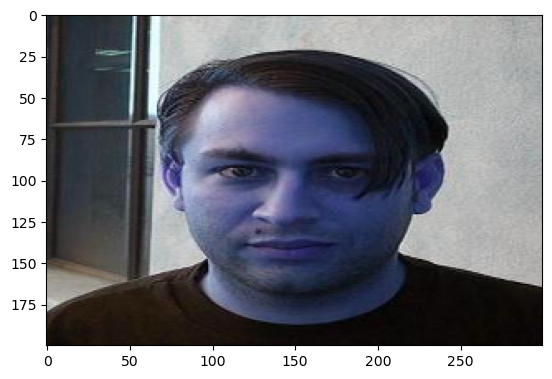

In [30]:
imshow(X[2323])

In [31]:
Y[1001]

'Motorbikes'

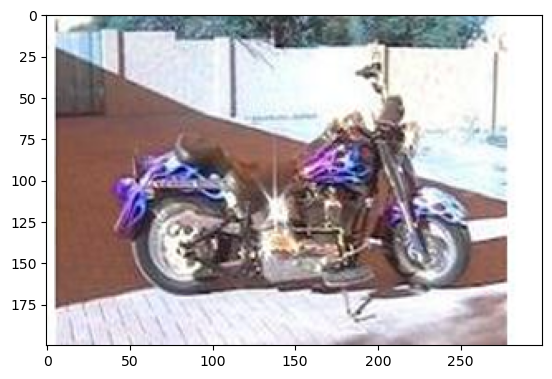

In [32]:
imshow(X[1001])

Seems all good.

### Making one-hot encoded labels

In [35]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([ 5,  5,  5, ..., 52, 52, 52], dtype=int64)

In [36]:
np.save('label_encoder.npy', label_encoder.classes_)

In [37]:
len(Y_integer_encoded)

8677

In [38]:
len(Y)

8677

In [39]:
len(X)

8677

Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane.
So, we must create a one-hot encoding.

In [41]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
Y_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
len(Y_one_hot[0])

101

To get back the label for any one-hot encoded label

In [45]:
predicted_class = label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])
print(predicted_class[0])


airplanes


### Basic Normalization (in case of images)

In [47]:
X_normalized = X.astype(np.float64) / 255

In [48]:
X[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [49]:
X_normalized[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [50]:
# We wouldn't require X anymore, so, let's free up some memory
del X

### Splitting the Data

In [52]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)

In [53]:
X_train.shape

(6507, 200, 300, 3)

In [54]:
Y_train.shape

(6507, 101)

Sanity Check

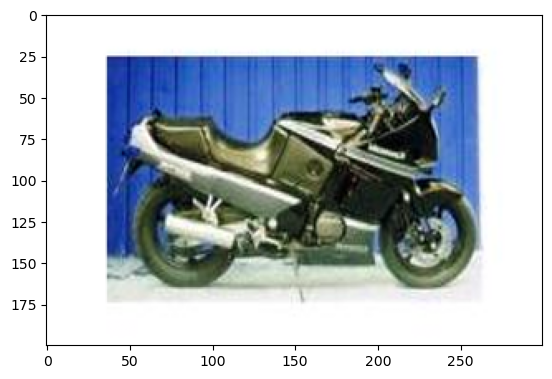

In [56]:
imshow(X_train[6001])

In [57]:
predicted_class = label_encoder.inverse_transform([np.argmax(Y_train[6001])])
print(predicted_class[0])


Motorbikes


## Saving notebook environment till here

In [59]:
#dill.dump_session('notebook_env_until_nn_models.db')
#dill.dump_module('notebook_env_until_nn_models.db')


## Approach 1 - A Small CNN

**Defining Model Architecture**

In [62]:
model_cnn = Sequential()
model_cnn.add(Input(shape=(200, 300, 3)))  # Explicit Input layer
model_cnn.add(Conv2D(16, (3,3), activation='relu'))
model_cnn.add(Conv2D(32, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(101, activation='softmax'))
model_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 146, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 94, 144, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 72, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 433152)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │    43,748,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,845,893 (167.26 MB)

 Trainable params: 43,845,893 (167.26 MB)

 Non-trainable params: 0 (0.00 B)

**Defining Loss and Optimizer**

In [64]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [65]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [66]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [67]:
callbacks = [ModelCheckpoint('cnn_model.weights.h5', monitor='val_acc', save_best_only=True, save_weights_only=True),
             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

model_cnn.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)




Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.2225 - loss: 5.7750 - val_accuracy: 0.4829 - val_loss: 2.4229
Epoch 2/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


102/102 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7644 - loss: 0.9953 - val_accuracy: 0.5253 - val_loss: 2.4895
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9696 - loss: 0.1262 - val_accuracy: 0.5392 - val_loss: 3.3721
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9948 - loss: 0.0301 - val_accuracy: 0.5682 - val_loss: 3.7623
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9981 - loss: 0.0135 - val_accuracy: 0.5548 - val_loss: 3.6887
Epoch 5: early stopping


In [68]:
json_cnn_model = model_cnn.to_json()
with open("model_cnn.json", "w") as f:
    json.dump(json.loads(json_cnn_model), f, indent=4)

As we see above, overfitting has happened. We could try some ways of avoiding overfitting :
    
* Dropout
* L2 regularization

## Approach 2 - CNN Model with Dropout

In [95]:
# Architecture
model_cnn_dropout = Sequential()
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Flatten())
model_cnn_dropout.add(Dense(512, activation='relu'))
model_cnn_dropout.add(Dropout(0.5))
model_cnn_dropout.add(Dense(101, activation='softmax'))
model_cnn_dropout.summary()

# loss and optimizer
model_cnn_dropout.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# training

callbacks = [ModelCheckpoint('cnn_model_dropout_two.weights.h5', monitor='val_acc', save_best_only=True, save_weights_only=True),
             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

model_cnn_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 196, 296, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 98, 148, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 96, 146, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 94, 144, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 47, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 216576)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │   110,887,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 101)            │        51,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,004,805 (423.45 MB)

 Trainable params: 111,004,805 (423.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 137s 328ms/step - accuracy: 0.1251 - loss: 4.2424 - val_accuracy: 0.2700 - val_loss: 3.5134
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 108s 265ms/step - accuracy: 0.2792 - loss: 3.4839 - val_accuracy: 0.3530 - val_loss: 3.1008
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 109s 268ms/step - accuracy: 0.3354 - loss: 3.1372 - val_accuracy: 0.3788 - val_loss: 2.8322
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 109s 268ms/step - accuracy: 0.3920 - loss: 2.7926 - val_accuracy: 0.4645 - val_loss: 2.5209
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 104s 256ms/step - accuracy: 0.4754 - loss: 2.3692 - val_accuracy: 0.4986 - val_loss: 2.3172
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 107s 262ms/step - accuracy: 0.5773 - loss: 1.7880 - val_accuracy: 0.5198 - val_loss: 2.1176
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 106s 260ms/step - accuracy: 0.7405 - loss: 1.0534 - val_accuracy: 0.5415 - val_loss: 2.1423
Epoch 8/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 105s 257ms/step - accuracy: 0.8646 -

In [97]:
# Train some more as val accuracy seems to be improving even though it still looks like overfit
model_cnn_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 113s 270ms/step - accuracy: 0.9495 - loss: 0.1937 - val_accuracy: 0.5442 - val_loss: 2.6206
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 107s 262ms/step - accuracy: 0.9678 - loss: 0.1059 - val_accuracy: 0.5507 - val_loss: 2.5402
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 105s 259ms/step - accuracy: 0.9732 - loss: 0.1052 - val_accuracy: 0.5530 - val_loss: 2.6996
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 104s 256ms/step - accuracy: 0.9810 - loss: 0.0764 - val_accuracy: 0.5613 - val_loss: 2.6152
Epoch 4: early stopping


In [218]:
model_cnn_dropout.save('model_cnn_dropout_with_weights.h5')

In [99]:
json_cnn_dropout = model_cnn_dropout.to_json()

In [100]:
with open("model_cnn_dropout.json", "w") as f:
    json.dump(json.loads(json_cnn_dropout), f, indent=4)

## Approach 3 - Transfer Learning

In [105]:
base_model = InceptionV3(weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(101, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)
transfer_learning_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, None,      │      5,120 │ max_pooling2d_8[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 24,477,573 (93.37 MB)

 Trainable params: 24,443,141 (93.24 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [106]:
#We freeze the model excepted the added layers
#279 is number of mixed 9 layer
#248 is number of mixed 8 layer

for layer in transfer_learning_model.layers[:280]:
    layer.trainable = False
for layer in transfer_learning_model.layers[280:]:
    layer.trainable = True

In [107]:
transfer_learning_model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, None,      │        864 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, None,      │      5,120 │ max_pooling2d_8[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 24,477,573 (93.37 MB)

 Trainable params: 8,748,325 (33.37 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [119]:
opt = Adadelta(learning_rate=1.0, rho=0.9, epsilon=1e-08)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [131]:
callbacks = [ModelCheckpoint('transfer_learning_weights.weights.h5', monitor='val_acc', save_best_only=True, save_weights_only=True),
             EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]

transfer_learning_model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 75s 326ms/step - accuracy: 0.4803 - loss: 2.4860 - val_accuracy: 0.8940 - val_loss: 0.3804
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step - accuracy: 0.9028 - loss: 0.3847 - val_accuracy: 0.9346 - val_loss: 0.2176
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 307ms/step - accuracy: 0.9551 - loss: 0.1715 - val_accuracy: 0.9429 - val_loss: 0.1990
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 62s 306ms/step - accuracy: 0.9739 - loss: 0.0874 - val_accuracy: 0.9475 - val_loss: 0.2179
Epoch 5/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 307ms/step - accuracy: 0.9826 - loss: 0.0563 - val_accuracy: 0.9516 - val_loss: 0.2046
Epoch 6/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 308ms/step - accuracy: 0.9908 - loss: 0.0306 - val_accuracy: 0.9525 - val_loss: 0.2113
Epoch 7/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 63s 310ms/step - accuracy: 0.9948 - loss: 0.0217 - val_accuracy: 0.9535 - val_loss: 0.2008
Epoch 7: early stopping


In [133]:
json_transfer_learning_model = transfer_learning_model.to_json()
with open("model_transfer_learning.json", "w") as f:
    json.dump(json.loads(json_transfer_learning_model), f, indent=4)

## Prediction from 2 models

#### Predicting for one image

In [153]:
dolphin_imgs = get_images('dolphin','data/caltech-101/')

In [155]:
dolphin_imgs[0]

'data/caltech-101/101_ObjectCategories\\dolphin\\image_0001.jpg'

In [156]:
img = read_image(dolphin_imgs[0])

In [157]:
img.shape

(200, 300, 3)

In [158]:
img = img.reshape((1,200,300,3))

In [159]:
prediction = model_cnn_dropout.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [166]:
label_predicted = label_encoder.inverse_transform([np.argmax(prediction)])
print(label_predicted[0])

dolphin


In [172]:
"""for var, obj in locals().items():
    print(var, sys.getsizeof(obj))"""

# Hacer una copia de locals() antes de iterar
locals_copy = locals().copy()

for var, obj in locals_copy.items():
    print(var, sys.getsizeof(obj))

__name__ 57
__doc__ 117
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 72
__builtins__ 72
_ih 1656
_oh 4688
_dh 64
In 1656
Out 4688
get_ipython 64
exit 56
quit 56
open 152
_ 88
__ 88
___ 88
__session__ 111
_i 1570
_ii 1570
_iii 1570
_i1 1570
json 72
getpass 72
hashlib 72
import_pandas_safely 152
__pandas 72
is_data_frame 152
dataframe_columns 152
dtypes_str 152
dataframe_hash 152
get_dataframes 152
_1 88
_i2 1570
_2 88
_i3 276
_exit_code 28
_i4 1222
urlretrieve 152
os 72
tarfile 72
zipfile 72
cv2 72
np 72
pprint 72
operator 72
imshow 152
LabelEncoder 1688
to_categorical 152
train_test_split 152
Sequential 1688
Model 1688
Conv2D 1688
Input 152
Dropout 1688
Activation 1688
Dense 1688
MaxPooling2D 1688
Flatten 1688
GlobalAveragePooling2D 1688
Adadelta 1688
ModelCheckpoint 1688
EarlyStopping 1688
load_model 152
InceptionV3 152
dill 72
sys 72
_i5 1570
_5 88
_i6 604
URL_CALTECH_101_DATA 126
download_dataset 152
_i7 1863
extract_dataset 152
_i8 1570
_8 88
_i9 749
get_images 152
read_ima

## Accuracy per category

In [174]:
def find_accuracy_per_category(data_directory, nn_model):
    category_accuracy_dict = {}
    for category,count in return_images_per_category(data_directory):
        correctly_classified = 0
        if category == 'BACKGROUND_Google':
            continue
        Y_category = [category for _ in range(count)]
        encoded = label_encoder.transform(Y_category)
        Y_category = to_categorical(encoded, num_classes=101)
        assert Y_category.shape == (count, 101)
        X_category = np.ndarray((count, 200, 300, 3), dtype=np.float64)
        for i,img in enumerate(get_images(category, data_directory)):
            if not img.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files
                continue
            X_category[i] = read_image(img) / 255
        score = nn_model.evaluate(x=X_category, y=Y_category, verbose=1)
        del X_category
        category_accuracy_dict[category] = score
    print("Accuracy found for each class")
    return category_accuracy_dict

In [185]:
# Testing first model
cnn_dropout_score_dict = find_accuracy_per_category('data/caltech-101', model_cnn_dropout)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9813 - loss: 0.1017
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9926 - loss: 0.0564
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9929 - loss: 0.0257
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9956 - loss: 0.0218
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9205 - loss: 0.4422
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9893 - loss: 0.0452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8760 - loss: 0.5395
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9862 - loss: 0.0575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9755 - loss: 0.1239
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9047 - loss: 0.5851
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8390 - loss: 0.8377
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9538 - loss: 0.2549
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9349 - loss: 0.4594
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.902

In [186]:
# Free memory - those variables which aren't needed
# del X
# del X_normalized

NameError: name 'X' is not defined

In [197]:
# Testing the dropout model
cnn_dropout_score_dict = find_accuracy_per_category('data/caltech-101', model_cnn_dropout)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9813 - loss: 0.1017
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9926 - loss: 0.0564
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9929 - loss: 0.0257
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9956 - loss: 0.0218
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9205 - loss: 0.4422
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9893 - loss: 0.0452
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8760 - loss: 0.5395
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9862 - loss: 0.0575
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9755 - loss: 0.1239
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9047 - loss: 0.5851
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8390 - loss: 0.8377
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9538 - loss: 0.2549
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9349 - loss: 0.4594
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9029

In [199]:
# Testing the transfer learning model
cnn_dropout_score_dict_transfer_learning = find_accuracy_per_category('data/caltech-101', transfer_learning_model)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.9919 - loss: 0.0341
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.9996 - loss: 4.2188e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9994 - loss: 0.0046
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9956 - loss: 0.0154
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 1.0000 - loss: 6.0416e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.9855 - loss: 0.0272
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9937 - loss: 0.0358
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 1.0000 - loss: 3.2920e-06
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9668 - loss: 0.1124
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.9852 - loss: 0.0944
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 1.0000 - loss: 1.5555e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 1.0000 - loss: 3.3925e-06
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9938 - loss: 0.0087
3/3 ━━━━━━━━━━━━━━━━━━━

In [201]:
average_accuracy = 0
for category, scores in cnn_dropout_score_dict.items():
    print(category,":",scores[1])
    average_accuracy += scores[1]
average_accuracy /= 101
print("Average accuracy : ",average_accuracy)

airplanes : 0.987500011920929
Motorbikes : 0.9924812316894531
Faces : 0.9908046126365662
Faces_easy : 0.9931034445762634
watch : 0.9288703203201294
Leopards : 0.9800000190734863
bonsai : 0.875
car_side : 0.9837398529052734
ketch : 0.9649122953414917
chandelier : 0.8971962332725525
hawksbill : 0.8500000238418579
grand_piano : 0.9494949579238892
brain : 0.9387755393981934
butterfly : 0.9230769276618958
helicopter : 0.7954545617103577
menorah : 0.9080459475517273
kangaroo : 0.8255813717842102
starfish : 0.8604651093482971
trilobite : 0.930232584476471
buddha : 0.8588235378265381
ewer : 0.7764706015586853
sunflower : 0.9647058844566345
scorpion : 0.773809552192688
revolver : 0.9268292784690857
laptop : 0.8641975522041321
ibis : 0.8374999761581421
llama : 0.8205128312110901
minaret : 0.9605262875556946
electric_guitar : 0.7866666913032532
umbrella : 0.8799999952316284
crab : 0.8219178318977356
crayfish : 0.7142857313156128
cougar_face : 0.8260869383811951
dragonfly : 0.8970588445663452
dalm

**So, as we can see, we achieve an average accuracy of 84% per category with our CNN models. This isn't bad.**

In [209]:
def find_average_accuracy_for_model(data_directory, nn_model):
    category_accuracy_dict = find_accuracy_per_category('data/caltech-101', transfer_learning_model)
    average_accuracy = 0
    for category, scores in category_accuracy_dict.items():
        print(category,":",scores[1])
        average_accuracy += scores[1]
    average_accuracy /= 101
    print("Average accuracy : ",average_accuracy)

In [211]:
find_average_accuracy_for_model('data/caltech-101',transfer_learning_model)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9919 - loss: 0.0341
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9996 - loss: 4.2188e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9994 - loss: 0.0046
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9956 - loss: 0.0154
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 1.0000 - loss: 6.0416e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9855 - loss: 0.0272
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.9937 - loss: 0.0358
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 1.0000 - loss: 3.2920e-06
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.9668 - loss: 0.1124
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.9852 - loss: 0.0944
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 1.5555e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 3.3925e-06
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9938 - loss: 0.0087
3/3 ━━━━━━━━━━━━━━━━━━━

**Average accuracy using transfer learning model : 98%**

## What else can we do?

Due to time constraints there are a lot of things I couldn't try right now, however could be done to :

**Improve our object classification**
- I'm certain that our CNN models could be optimized further. The dataset is quite an easy one compared to likes of imagenet, so a simple model should be able to work quite well if optimized well
- Add visualizations of losses and training and predictions
- Try other algorithms and other NN architectures

**Do Object Detection**
Currently, if you look at this dataset, most of the images are clutter free, containing image of only one object, which is also centered in most of the cases. This makes this dataset less challenging for object detection problem. Also, one could perhaps just have a bad version of sliding window or R-CNN algorithm which could do detection problem here and give good boundary boxes.

However, to improve upon that, YOLO and SSD algorithms could be used to detect where which object is in an image.

In [216]:
transfer_learning_model.save('transfer_learning_model.h5')

In [220]:
transfer_learning_model.save('transfer_learning_model.keras')

In [226]:
# Cargar el modelo
model = tf.keras.models.load_model('transfer_learning_model.keras')

# Supongamos que la última capa de tu modelo es una capa Dense con softmax
output_layer = model.layers[-1]

# Si la última capa es una capa Dense, puedes obtener el número de unidades
num_classes = output_layer.units
print(f"El modelo tiene {num_classes} clases.")

# Si se usó un mapeo en el entrenamiento, deberías tenerlo en tu pipeline de preprocesamiento.
# Pero sin acceso directo al generador de entrenamiento, es difícil deducir los nombres de las clases solo del modelo.


El modelo tiene 101 clases.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [228]:
# Cargar el LabelEncoder si está guardado en un archivo
label_encoder = np.load('label_encoder.npy', allow_pickle=True)

# Obtener las clases
class_labels = list(label_encoder)

# Guardar en un archivo JSON
with open('class_labels.json', 'w') as json_file:
    json.dump(class_labels, json_file)

print("Las clases han sido guardadas en 'class_labels.json'.")

Las clases han sido guardadas en 'class_labels.json'.


In [230]:
# Directorio donde se encuentran las imágenes de tu conjunto de datos
data_dir = 'data/caltech-101'

# Cargar el modelo preentrenado
model = tf.keras.models.load_model('transfer_learning_model.keras')

# Crear un extractor de características a partir del modelo
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Listas para almacenar las características y las rutas de las imágenes
features_list = []
image_paths = []


In [ ]:
from tensorflow.keras.preprocessing import image

# Extraer características de todas las imágenes en las subcarpetas del directorio especificado
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg', 'gif')):
            img_path = os.path.join(root, file)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalización si es necesario
            
            features = feature_extractor.predict(img_array)
            features_list.append(features.flatten())
            image_paths.append(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [236]:
# Convertir la lista de características en un array de numpy
features_array = np.array(features_list)

# Guardar las características y las rutas de las imágenes en archivos .npy
np.save('feature_index.npy', features_array)
np.save('image_paths.npy', image_paths)

print("Índice de características guardado en 'feature_index.npy' y rutas de imágenes en 'image_paths.npy'.")


Índice de características guardado en 'feature_index.npy' y rutas de imágenes en 'image_paths.npy'.


In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Directorio donde se encuentran las imágenes de tu conjunto de datos
data_dir = 'data/caltech-101/101_ObjectCategories'

# Cargar el modelo preentrenado
model = tf.keras.models.load_model('transfer_learning_model.keras')

# Crear un extractor de características a partir del modelo
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Listas para almacenar las características y las rutas de las imágenes
features_list = []
image_paths = []

# Extraer características de todas las imágenes en las subcarpetas del directorio especificado
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('png', 'jpg', 'jpeg', 'gif')):
            img_path = os.path.join(root, file)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Normalización si es necesario
            
            features = feature_extractor.predict(img_array)
            features_list.append(features.flatten())
            # Guardar rutas relativas desde 'data/caltech-101/101_ObjectCategories'
            relative_img_path = os.path.relpath(img_path, data_dir)
            image_paths.append(relative_img_path)

# Convertir la lista de características en un array de numpy
features_array = np.array(features_list)

# Guardar las características y las rutas de las imágenes en archivos .npy
np.save('feature_index.npy', features_array)
np.save('image_paths.npy', image_paths)

print("Índice de características guardado en 'feature_index.npy' y rutas de imágenes en 'image_paths.npy'.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━